In [1]:
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:

framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [3]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [4]:
# Define the input shape and create the input tensor
input_shape = (256, 256, 3)
inputs = tf.keras.layers.Input(shape=input_shape)

# Create the UNet model
unet = GiveMeUnet(inputs, numFilters=16, droupouts=0.07, doBatchNorm=True)

# Compile the model
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
unet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [5]:
framObjTrain = LoadData( framObjTrain, imgPath = r'Data\Images\archive\train', 
                        maskPath = r'Data\Images\archive\train'
                         , shape = 256)
                         

In [6]:
img=framObjTrain['img'][:1000:]
mask=framObjTrain['mask'][:1000:]

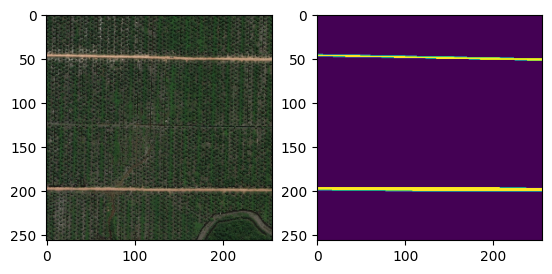

In [7]:
plt.subplot(1,2,1)
plt.imshow(img[1])
plt.subplot(1,2,2)
plt.imshow(mask[1])
plt.show()

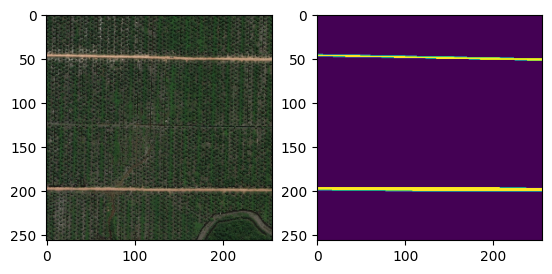

In [8]:
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [9]:
# retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 5, verbose = 1)
retVal = unet.fit(np.array(img), np.array(mask), epochs = 50, verbose = 1)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 455s 12s/step - accuracy: 0.9091 - loss: 0.3838
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 384s 12s/step - accuracy: 0.9540 - loss: 0.2405
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 391s 12s/step - accuracy: 0.9511 - loss: 0.2041
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 390s 12s/step - accuracy: 0.9507 - loss: 0.1875
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2783s 89s/step - accuracy: 0.9520 - loss: 0.1735


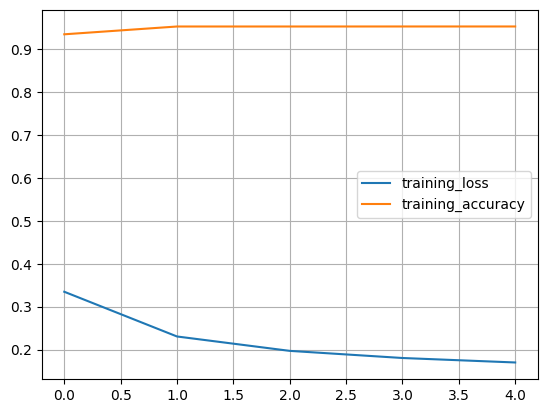

In [10]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [11]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    print(predictions[1].shape)  
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')
    

In [12]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step
(256, 256, 1)


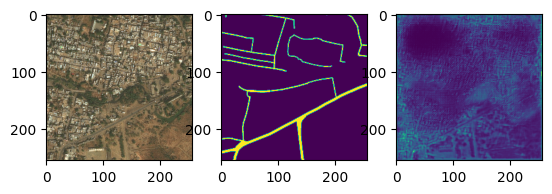

In [13]:
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.imshow(actuals[2])
plt.subplot(1,3,2)
plt.imshow(masks[2])
plt.subplot(1,3,3)
mat_256_256 = np.squeeze(sixteenPrediction[2])
plt.imshow(mat_256_256)

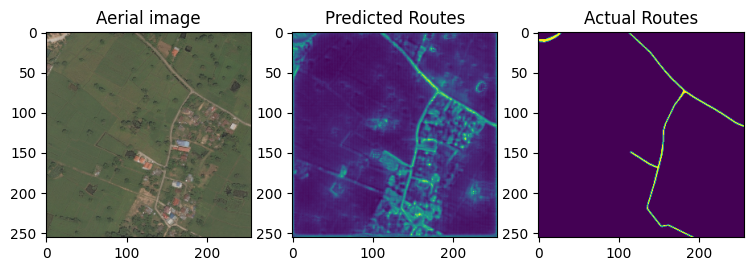

In [14]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

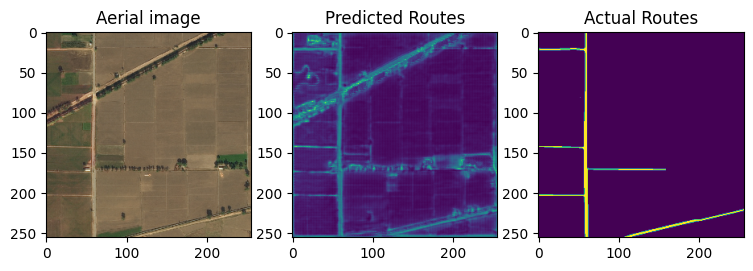

In [15]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

In [16]:
# def predict16(valMap, model, shape=256):
#     ## getting and processing val data
#     img = np.array(valMap['img'][0:16])
#     mask = np.array(valMap['mask'][0:16])
    
#     # Normalize images if necessary
#     img = img / 255.0
    
#     predictions = model.predict(img)
  
#     return predictions, img, mask

# def Plotter(img, predMask, groundTruth):
#     plt.figure(figsize=(15, 5))
    
#     for i in range(len(img)):
#         plt.subplot(3, len(img), i+1)
#         plt.imshow(img[i])
#         plt.title('Aerial Image')
        
#         plt.subplot(3, len(img), i+len(img)+1)
#         plt.imshow(predMask[i, :, :, 0], cmap='gray')
#         plt.title('Predicted Routes')
        
#         plt.subplot(3, len(img), i+2*len(img)+1)
#         plt.imshow(groundTruth[i], cmap='gray')
#         plt.title('Actual Routes')
    
#     plt.tight_layout()
#     plt.show()

# # Assuming valMap is your validation dataset
# predictions, imgProc, mask = predict16(valMap, model)

# # Plotting the first example
# Plotter(imgProc[:3], predictions[:3], mask[:3])


In [17]:
model.save('model/model1.h5')

NameError: name 'model' is not defined